C:\Users\dstek\AppData\Local\Temp\ipykernel_12548\2762894780.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  projectile_df = pd.read_csv("big_green_reversed_1.csv", index_col=False)


53
7
[-1.49816446  0.04163423  2.20231184  4.79680947 -0.66764276  0.25573985
  0.         -9.80665     0.        ]
16
Time for kalman filter is 0.024489164352416992 seconds
[(0.0009114737740953949, 0.0012187586891600488, -0.0006496785120795323), (0.0038346470020224066, 0.0016301826059768043, -0.009283827090319718), (0.0055272058478058606, 0.004391828017213245, -0.006984711243071651), (0.008420348716323356, 0.009030423178596259, -0.022151331860133183), (0.010266173772903953, 0.01262334566773271, -0.025462670826812417), (0.006438464794900345, 0.017991375967492063, -0.019079309856850468), (0.016948902735850202, 0.030101023339506205, -0.06636614008432673), (0.013728538788178202, 0.03850809651575382, -0.08502938730255272), (0.010594315716385083, 0.049435715089691024, -0.08211861395049658), (-1.5055867495631226, -0.024831358319840513, 0.4257614765964197), (0.0035096303221078193, 0.07793217948532394, -0.09734360968993272), (-0.0014402003778972161, 0.08939400930880803, -0.10353080752100174), 

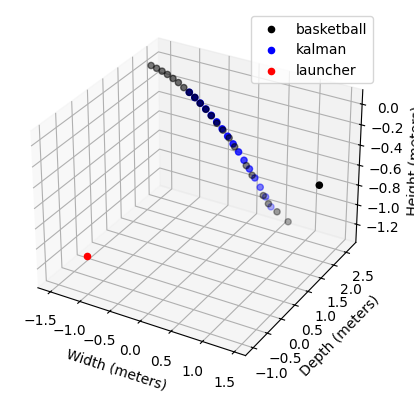

In [37]:

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.animation as animation
from sympy import Symbol, solve
from math import*
from pykalman import KalmanFilter


projectile_x = []
projectile_x = projectile_x[5:]
projectile_x = projectile_x /25.4
projectile_y = []
projectile_y = projectile_y /25.4 
projectile_y = projectile_y[5:]
projectile_z = []
projectile_z = projectile_z /25.4
projectile_z = projectile_z[5:]


#framerate = 11/(projectile_df.iloc[10]['time']-projectile_df.iloc[0]['time'])
framerate = 53
initial_x = []
initial_y = []
initial_z = []
initial_velocity = (projectile_y[1] - projectile_y[0]) * framerate
initial_x_velocity = ((projectile_x[1]-projectile_x[0]) + (projectile_x[2]-projectile_x[1]) + (projectile_x[3]-projectile_x[2]))/3 * framerate
initial_z_velocity=  ((projectile_z[1]-projectile_z[0]) + (projectile_z[2]-projectile_z[1]) + (projectile_z[3]-projectile_z[2]))/3 * framerate
dT = 1 / framerate
g = 9.80665
initial_state = np.asarray([projectile_x[0],projectile_y[0],projectile_z[0],initial_x_velocity,initial_velocity,initial_z_velocity,0,-1*g,0])
transition_matrix = np.asarray(
    [
        [1., 0., 0., dT, 0., 0., 0.5*dT*dT, 0., 0.], # x pos
        [0., 1., 0., 0., dT, 0., 0., 0.5*dT*dT, 0.], # y pos
        [0., 0., 1., 0., 0., dT, 0., 0., 0.5*dT*dT], # z pos
        [0., 0., 0., 1., 0., 0., dT, 0., 0.], # x velocity
        [0., 0., 0., 0., 1., 0., 0., dT, 0.], # y velocity
        [0., 0., 0., 0., 0., 1., 0., 0., dT], # z velocity
        [0., 0., 0., 0., 0., 0., 1., 0., 0.], # x accel
        [0., 0., 0., 0., 0., 0., 0., 1., 0.], # y accel
        [0., 0., 0., 0., 0., 0., 0., 0., 1.] # z accel
    ]
)
observation_matrix = np.asarray(
    [
        [1, 0, 0, 0, 0, 0,0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0]
    ]
)





kf1 = KalmanFilter(transition_matrices = transition_matrix,
                observation_matrices = observation_matrix,
                initial_state_mean = initial_state)
measurements = []

for values in zip(projectile_x,projectile_y,projectile_z):
    measurements.append(values)

time1 = time.time()
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)
next_mean = smoothed_state_means[-1]
next_covar = smoothed_state_covariances[-1]
predicted_error = []
predicted_state_means = []
predicated_state_covariances = []
pitch = []
yaw = []
launcher_offset = (-1,-1,-1)
predict_count  = 1
degree_speed = 191 # degrees per second
yaw_distance = []
time_to_prediction = []
time_advantage = []
time_per_frame = 1/framerate
yaw_time  = []
time_to_predict = time.time() - time1
advantage_count = 0
while True:
    next_mean, next_covar = kf1.filter_update(next_mean,next_covar)
    predicted_state_means.append(next_mean)
    predicated_state_covariances.append(next_covar)
    time_to_prediction.append(predict_count*time_per_frame - time_to_predict)
    predict_count = predict_count + 1
    launcher_distance = tuple(np.subtract(next_mean[0:3],launcher_offset))
    yaw.append(90-math.degrees(np.arctan(launcher_distance[2]/launcher_distance[0])))
    yaw_distance.append(abs(90-math.degrees(np.arctan(launcher_distance[2]/launcher_distance[0]))))
    yaw_time.append(yaw_distance[-1]/degree_speed)
    time_advantage.append(time_to_prediction[-1]- (yaw_distance[-1]/degree_speed) )
    if time_advantage[-1] > 0:
        advantage_count = advantage_count + 1
        if advantage_count >= 5:
            break
    pitch.append(math.degrees(np.arctan(launcher_distance[1]/(np.sqrt(np.power(launcher_distance[2],2) + np.power(launcher_distance[0],2))))))
time2 = time.time()
predicted_state_means = np.array(predicted_state_means)
print("Time for kalman filter is " + str(time2-time1) + " seconds")
print(f"Optimal pitch is{pitch[-1]} and yaw is {yaw[-1]}")

